<a href="https://colab.research.google.com/github/Joycelyn96/Project-1/blob/main/Project_3_JE_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time Series and Analysis and Forecasting: "Air Passengers**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
import warnings
import statsmodels.api as sm
import statsmodels.tsa.api as smt



from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/AirPassengers.csv', parse_dates = ['Month'], index_col = ['Month'])

Mounted at /content/gdrive


In [ ]:
df.describe()


,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [ ]:
df.head(10)


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [ ]:
df.tail(10)

,#Passengers
Month,
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


In [ ]:
df.shape

(144, 2)

Loading the dataset

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/AirPassengers.csv')
df.set_index('Month', inplace=True)
df.index = pd.to_datetime(df.index, format='%Y-%m')

value = df['#Passengers']

**No null values presented in the data**

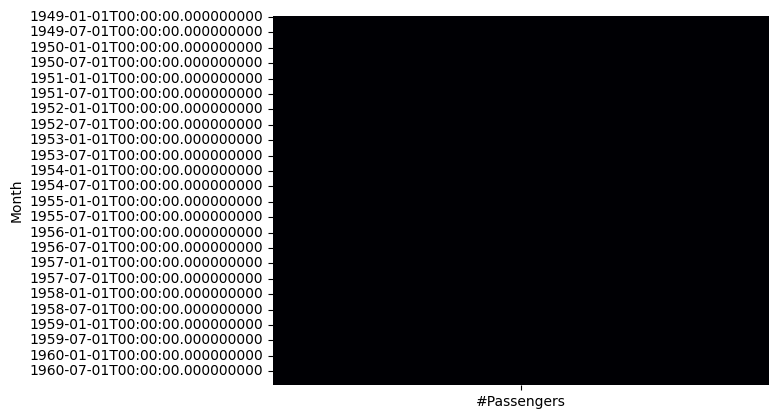

In [ ]:
sns.heatmap(df.isnull(),cmap = 'magma',cbar = False);

Performing the EDA and data visualization

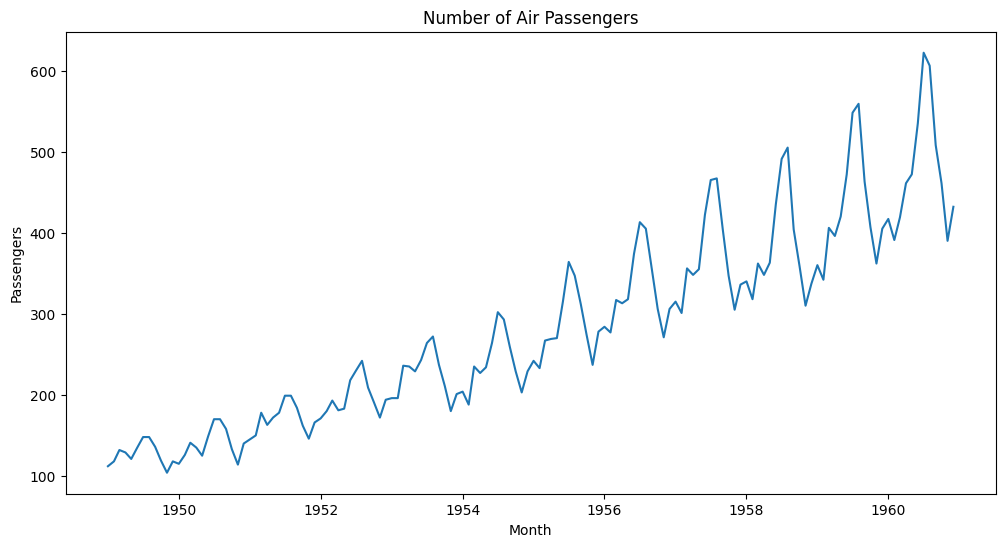

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.title('Number of Air Passengers')
plt.show()

Decomposing the Time Series: As you can see we will decompose the time series data to identify any underlying patterns. Decomposing the time series can help us separate the data into the individual components such as the trends, seasonality, and residuals which is going to be analyzed separately. There are two main models used for time series decomposition (addidtive and multiplicative).

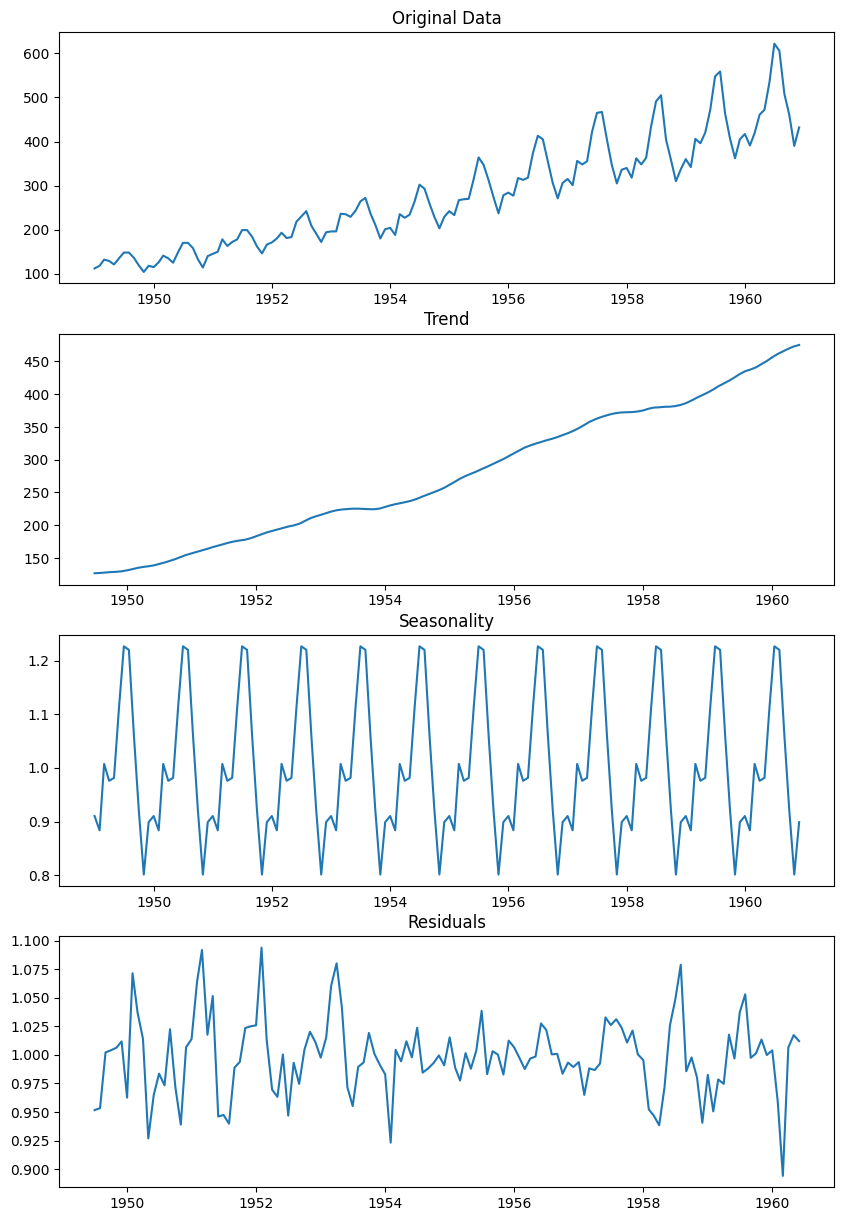

In [ ]:
decomp = seasonal_decompose(df["#Passengers"], period = 12, model= "multiplicative")
fig, axs = plt.subplots(4, 1, figsize=(10, 15))
axs[0].plot(df)
axs[0].set_title('Original Data')
axs[1].plot(decomp.trend)
axs[1].set_title('Trend')
axs[2].plot(decomp.seasonal)
axs[2].set_title('Seasonality')
axs[3].plot(decomp.resid)
axs[3].set_title('Residuals')
plt.show()

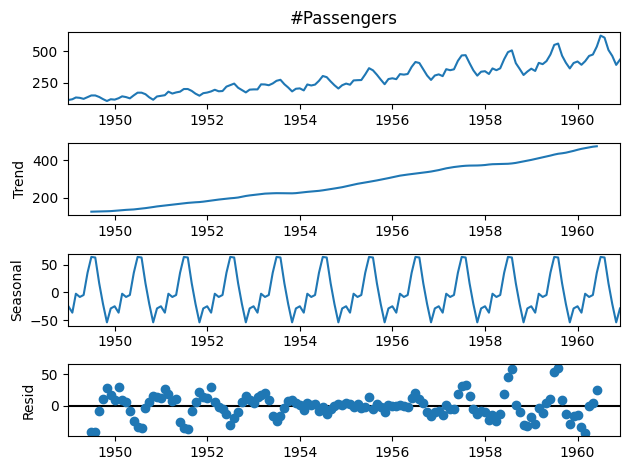

In [ ]:
decomp = seasonal_decompose(df["#Passengers"], period = 12, model= "additive")
decomp.plot()
plt.show()

Plotting the ACF and PACF: Autocorrelation (ACF) is a plot correlation of a time series with its lagged values. Partial Autocoorelation (PACF) is a plot of the correlation between a time series and a lagged version of itself after removing the effect of the correlations at shorter lags. They are both useful because ACF and PACF plots are useful in identifying the order of the ARIMA model.

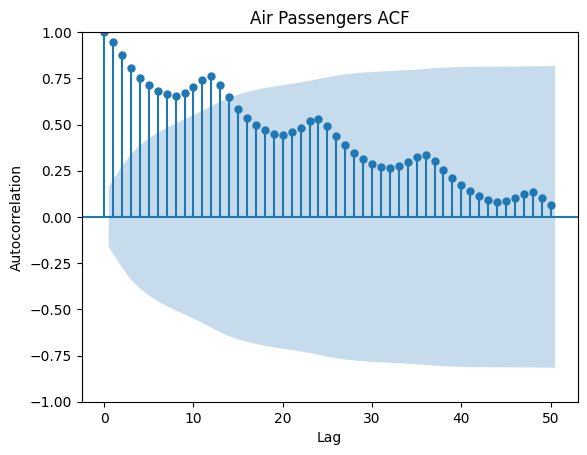

In [ ]:
# Plot the auto-correlation function (ACF)
plot_acf(df, lags=50)
plt.title('Air Passengers ACF')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

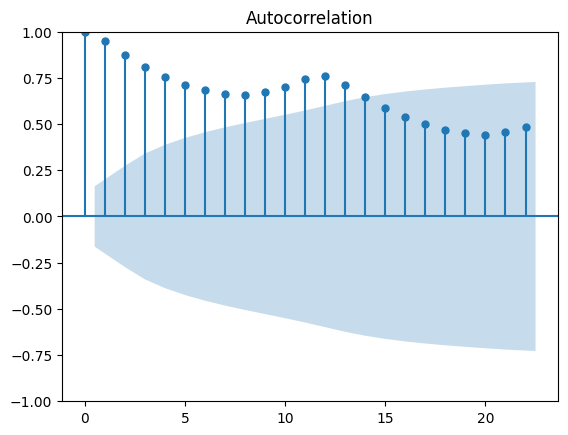

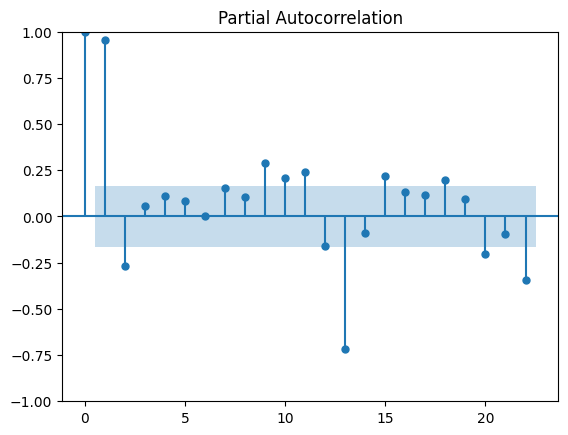

In [ ]:
plot_acf(df["#Passengers"])
plt.show()

plot_pacf(df["#Passengers"])
plt.show()

Splitting the data into training and training tests:

In [ ]:
# Split the data into train and test sets
train = df[:'1959']
test = df['1960':]

Testing the stationary of the time series using ADF test: ADF is the statistical test that is used to test the stationary of a time series. For instance, stationary in ADF is an important assumption for many time series models, including ARIMA. It is used to apply statistical properties such as the mean and the variance which does not change over time. Furthermore, ADF tests the null hypothesis that a unit root present in the time series (non-stationary). When performing the ADF test, I decided to add the adfuller functions from the statsmodels library. The ADF statistic is past the critical values and the p-value is greater than the threshold (0.05)

In [ ]:
result = adfuller(df["#Passengers"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


**Based on the graph, I decided to add rolling statistics into the dataframe because before we ensure that the time series is stationary we would do the rolling statistics to determine the rolling mean and rolling standard deviation. The only way we would determine the time series is stationary is if they would remain constant within time. When applying ADF, we would determine the time series is stationary if the p-value is low. Overall based on the graph below the rolling mean and the rolling standard deviation increased which means the time series is not stationary.**

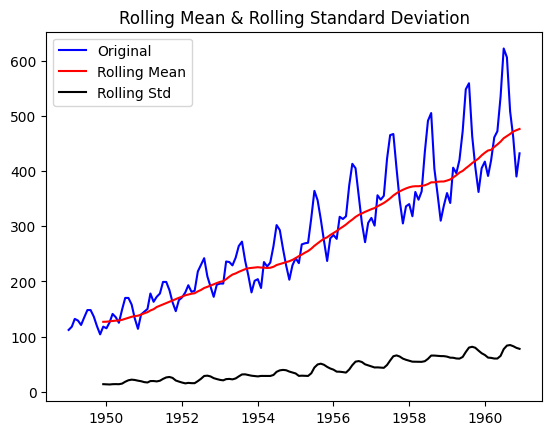

In [ ]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Building and evaluating the ARIMA models: Building the ARIMA model involves selecting appropriate model parameters and fitting the model to the training data. The model is then used to make predictions on the test data, and the performance of the model is evaluated using various metrics such as the mean square error (MSE), root mean squared error (RMSE), mean absolute percentage error (MAPE).

In [ ]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

model = ARIMA(train["#Passengers"], order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))
mse = mean_squared_error(test["#Passengers"], forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test["#Passengers"] - forecast) / test["#Passengers"])) * 100

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 97.49961967649381
MAPE: 21.291348973135054


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


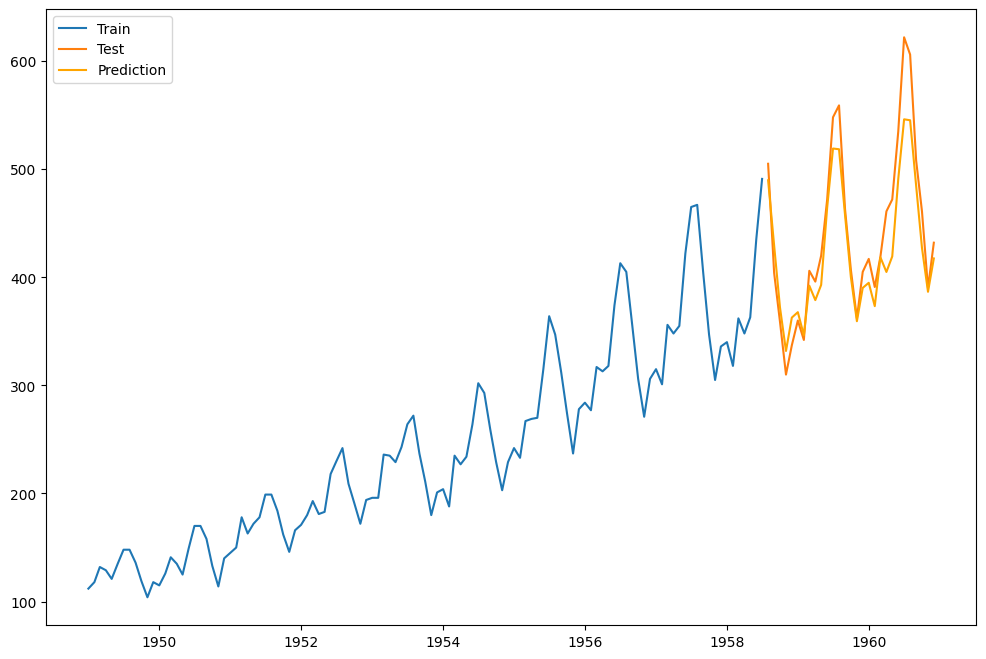

The RMSE of the forecasts is 30.14185280382133


In [ ]:
# Define the SARIMA model
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))

# Fit the model
model_fit = model.fit(disp=-1)

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the predictions
plt.figure(figsize=(12, 8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction', color='orange')
plt.legend(loc='upper left')
plt.show()
# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'The RMSE of the forecasts is {rmse}')

In [ ]:
error = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 16.9251


In [ ]:
# Evaluate and compare ARIMA and SARIMA models
def evaluate_model(model, order, seasonal_order):
    # Check seasonal orders
    if seasonal_order is None:
        mod = model(df['#Passengers'].values, order=order, enforce_stationarity=False, enforce_invertibility=False)
    else:
        mod = model(df['#Passengers'].values, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit(disp=-1)
    pred = results.predict(start=131, end=144, typ='levels')
    error = sqrt(mean_squared_error(df['#Passengers'][131:], pred))
    print('RMSE:', error)

**Plotting the Air Passengers Forecast**

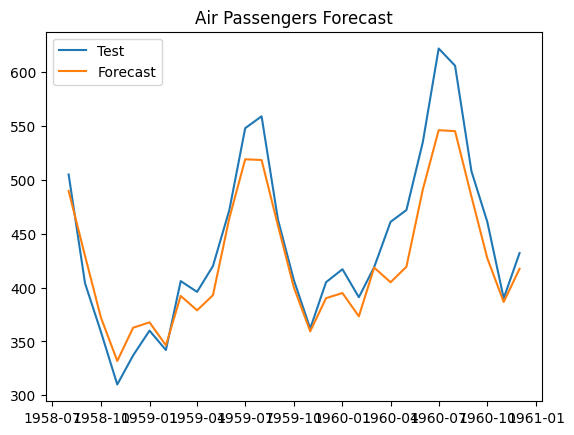

In [ ]:
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.title('Air Passengers Forecast')
plt.legend()
plt.show()


In [ ]:
model = ARIMA(df['#Passengers'], order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Wed, 10 May 2023   AIC                           1353.347
Time:                        06:03:35   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.061      0.000       1.645       1.725
ar.L2         -0.9549      0.017    -55.420      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.845      0.0

**For the out of sample forecasting, the rolling method is used by the forecast function and predicting the function. In the rolling method, the idea is to predict the next single value then use the predicted value for model fitting that is then used to predict the next value.**

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(weeks = x) for x in range(0,49)]

# New dataframe for storing the future values
df1 = pd.DataFrame(index = future_dates[1:],columns = df.columns)

forecast = pd.concat([df,df1])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.head()

,#Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


In [ ]:
sum(f1) == sum(f2)

True

**In Sample Forecasting the model forecasts values for the existing data of the time series. For instance, in the dataframe below, we use the rolling forecast method to predict a single value and use the predicted value again for model fitting for predicting the next value.**

In [ ]:
size = int(len(df) - 30)
train, test = df['#Passengers'][0:size], df['#Passengers'][size:len(df)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):

    model = sm.tsa.statespace.SARIMAX(history,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()

    output = model_fit.forecast()

    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print('predicted = %f, expected = %f' % (yhat, obs))

	 SARIMA MODEL : In - Sample Forecasting 

predicted = 479.085765, expected = 491.000000
predicted = 490.553509, expected = 505.000000
predicted = 441.276125, expected = 404.000000
predicted = 357.274099, expected = 359.000000
predicted = 315.250484, expected = 310.000000
predicted = 347.831879, expected = 337.000000
predicted = 344.251448, expected = 360.000000
predicted = 336.839209, expected = 342.000000
predicted = 387.593116, expected = 406.000000
predicted = 387.333485, expected = 396.000000
predicted = 408.192789, expected = 420.000000
predicted = 485.988165, expected = 472.000000
predicted = 529.031343, expected = 548.000000
predicted = 551.914006, expected = 559.000000
predicted = 459.061270, expected = 463.000000
predicted = 411.970100, expected = 407.000000
predicted = 358.421153, expected = 362.000000
predicted = 384.945724, expected = 405.000000
predicted = 420.144085, expected = 417.000000
predicted = 397.755393, expected = 391.000000
predicted = 451.335502, expected = 41